### Example training

In [1]:
import random
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from recipes import train_vessel_manual as train_pytorch
import torchtrainer

params = {
    # Dataset
    'img_dir': Path('../data/vessel_manual/images'),
    'label_dir': Path('../data/vessel_manual/labels'),      
    'train_val_split': 0.1,
    # Model
    'model_layers': (1, 1, 1), 
    'model_channels': (16,32,64), 
    'model_type': 'unet',
    # Training
    'epochs': 200,
    'lr': 0.01,
    'batch_size_train': 8,
    'batch_size_valid': 8, 
    'momentum': 0.9,
    'weight_decay': 0.,
    'seed': 12,
    'loss': 'cross_entropy',
    'scheduler_power': 0.9,
    'class_weights': (0.3414, 0.6586),
    # Efficiency
    'device': 'cuda',
    'num_workers': 3,  # 3 is a good compromise
    'use_amp': True,
    'pin_memory': False,
    'non_blocking': False,
    # Logging
    'log_dir': '../logs_vessel_manual',
    'experiment':'unet_l_1_1_1_c_16_32_64',
    'save_every':1,                
    'save_best':True,
    # Other
    'resume': False,
}

#Train using pure Pytorch
logger, ds_train, ds_valid, model = train_pytorch.run(params)

Epoch 1/1000
Batch 12/12, Train loss: 0.39058902859687805
Epoch finished in 13.1 seconds
Train loss: 0.8892921560340458, Valid loss: 0.7887055277824402, IoU: 0.6312088370323181, Prec: 0.7268484234809875, Rec 0.831296443939209
Epoch 2/1000
Batch 12/12, Train loss: 0.20177322626113892
Epoch finished in 0.4 seconds
Train loss: 0.33689122597376503, Valid loss: 0.4741237163543701, IoU: 0.6748331189155579, Prec: 0.8000057339668274, Rec 0.8140961527824402
Epoch 3/1000
Batch 12/12, Train loss: 0.23615537583827972
Epoch finished in 0.4 seconds
Train loss: 0.2601142668061786, Valid loss: 0.372917115688324, IoU: 0.6634646654129028, Prec: 0.7638950347900391, Rec 0.8364362716674805
Epoch 4/1000
Batch 12/12, Train loss: 0.23224087059497833
Epoch finished in 0.4 seconds
Train loss: 0.23877198199431102, Valid loss: 0.3254929184913635, IoU: 0.6789608597755432, Prec: 0.7723559141159058, Rec 0.8508045077323914
Epoch 5/1000
Batch 12/12, Train loss: 0.19592081010341644
Epoch finished in 0.4 seconds
Train l

### View results

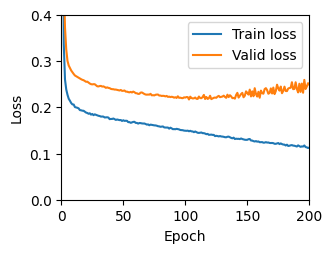

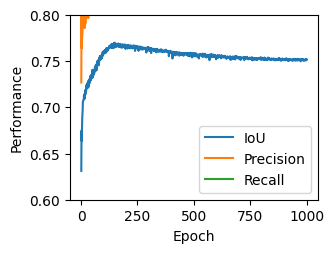

In [3]:
# Plot results

def plot_metrics(logger, type='lt'):
    '''Plot losses and IoU. `lt` is the logger used in Lightning.'''

    if type=='lt':
        metrics = logger.metrics
        epochs, _ = zip(*metrics['val_loss'])
        metrics = [list(zip(*metrics[k]))[1] for k in ['train_loss', 'val_loss', 'iou', 'prec', 'rec']]
        train_loss, valid_loss, iou, prec, rec = metrics    
    elif type=='pt':
        epochs, metrics = zip(*logger.data.items())
        train_loss, valid_loss, iou, prec, rec = zip(*metrics)

    plt.figure()
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, valid_loss, label='Valid loss')
    plt.ylim((0, 0.4))
    plt.xlim((0, 200))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.figure()
    plt.plot(epochs, iou, label='IoU')
    plt.plot(epochs, prec, label='Precision')
    plt.plot(epochs, rec, label='Recall')
    plt.ylim((0.6, 0.8))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Performance')

def plot_examples(ds, model, n=4):
    """Plot some example segmentations"""

    model.eval()
    model.cuda()
    indices = random.sample(range(len(ds)),n)
    for i, idx in enumerate(indices):
        x, y = ds[idx]
        x_or, y_or = ds.get_item(idx)
        with torch.no_grad():
            y_pred = model(x[None].cuda())[0].cpu()
        x = x[0]
        y_pred = torch.max(y_pred, dim=0)[1]

        plt.figure(figsize=[20,5])
        plt.subplot(1, 4, 1)
        plt.imshow(x_or, 'gray')
        plt.title('Original image')
        plt.subplot(1, 4, 2)
        plt.imshow(x, 'gray')
        plt.title('Augmented image')
        plt.subplot(1, 4, 3)
        plt.imshow(y, 'gray')
        plt.title('Ground truth')
        plt.subplot(1, 4, 4)
        plt.imshow(y_pred, 'gray')
        plt.title('Prediction')

plot_metrics(logger, type='pt')
#plot_examples(ds_valid, model)

### Analyze model statistics

In [6]:
# Check if output values are too large
model.eval()
model.to('cuda')
stats = []
with torch.no_grad():
    for idx, (x, y) in enumerate(ds_valid):
        if idx%10==0:
            print(idx)
        output = model(x[None].to('cuda'))[0].to('cpu')
        stats.append((idx, output.min(), output.max()))
stats

0


[(0, tensor(-64.0225), tensor(24.8368)),
 (1, tensor(-37.0607), tensor(13.7886)),
 (2, tensor(-32.1525), tensor(12.9102)),
 (3, tensor(-38.5950), tensor(13.4953)),
 (4, tensor(-34.7780), tensor(16.4175)),
 (5, tensor(-23.4627), tensor(11.7179)),
 (6, tensor(-34.4972), tensor(13.7270)),
 (7, tensor(-29.1929), tensor(11.6199)),
 (8, tensor(-55.4941), tensor(14.5814)),
 (9, tensor(-38.3041), tensor(16.2493))]

In [7]:
# Check performance
model.eval()
model.to('cuda')
stats = []
with torch.no_grad():
    for idx, (x, y) in enumerate(ds_valid):
        output = model(x[None].to('cuda')).to('cpu')
        acc = torchtrainer.perf_funcs.segmentation_accuracy(output, y[None], ('iou', 'prec', 'rec'))
        stats.append((idx, *list(acc.items())))
stats

[(0,
  ('iou', tensor(0.8441)),
  ('prec', tensor(0.8488)),
  ('rec', tensor(0.9935))),
 (1,
  ('iou', tensor(0.6121)),
  ('prec', tensor(0.6329)),
  ('rec', tensor(0.9489))),
 (2,
  ('iou', tensor(0.7782)),
  ('prec', tensor(0.8197)),
  ('rec', tensor(0.9389))),
 (3,
  ('iou', tensor(0.6989)),
  ('prec', tensor(0.7092)),
  ('rec', tensor(0.9797))),
 (4,
  ('iou', tensor(0.8589)),
  ('prec', tensor(0.9151)),
  ('rec', tensor(0.9333))),
 (5,
  ('iou', tensor(0.6302)),
  ('prec', tensor(0.6354)),
  ('rec', tensor(0.9873))),
 (6,
  ('iou', tensor(0.7270)),
  ('prec', tensor(0.8121)),
  ('rec', tensor(0.8740))),
 (7,
  ('iou', tensor(0.6979)),
  ('prec', tensor(0.7146)),
  ('rec', tensor(0.9677))),
 (8,
  ('iou', tensor(0.4749)),
  ('prec', tensor(0.4750)),
  ('rec', tensor(0.9995))),
 (9,
  ('iou', tensor(0.7884)),
  ('prec', tensor(0.7928)),
  ('rec', tensor(0.9931)))]

In [8]:
# Check intermediate activations of the model
insp = torchtrainer.inspector.Inspector(model)
insp.start_tracking_activations()

model.eval()
model.to('cuda')
with torch.no_grad():
    output = model(ds_valid[0][0][None].to('cuda'))
acts = insp.get_activations()

stats = []
for k, v in acts.items():
    if v is not None:
        stats.append((k, v.min(), v.max()))
stats

[('litseg.model.conv1', tensor(-23.9948), tensor(28.5901)),
 ('litseg.model.bn1', tensor(-13.7820), tensor(13.7432)),
 ('litseg.model.relu', tensor(0.), tensor(13.7432)),
 ('litseg.model.encoder.stage_0.0.conv1', tensor(-46.2537), tensor(42.8798)),
 ('litseg.model.encoder.stage_0.0.bn1', tensor(-16.3660), tensor(20.0193)),
 ('litseg.model.encoder.stage_0.0.relu1', tensor(0.), tensor(20.0193)),
 ('litseg.model.encoder.stage_0.0.conv2', tensor(-50.0530), tensor(55.3143)),
 ('litseg.model.encoder.stage_0.0.bn2', tensor(-22.2832), tensor(22.9372)),
 ('litseg.model.encoder.stage_0.0.relu2', tensor(0.), tensor(36.0959)),
 ('litseg.model.encoder.stage_0.0.downsample.0',
  tensor(-16.9323),
  tensor(24.5988)),
 ('litseg.model.encoder.stage_0.0.downsample.1',
  tensor(-18.4771),
  tensor(17.8221)),
 ('litseg.model.encoder.stage_0.0.downsample',
  tensor(-18.4771),
  tensor(17.8221)),
 ('litseg.model.encoder.stage_0.0', tensor(0.), tensor(36.0959)),
 ('litseg.model.encoder.stage_0', tensor(0.), 

In [9]:
# Benchmark model

model = torchtrainer.models.resunet.ResUNet((3,3,3), (16,32,64))
stats_train = torchtrainer.profiling.benchmark_model(model, (8, 1, 256, 256), no_grad=False, call_backward=True, use_float16=True, return_model_info=False)
stats_val = torchtrainer.profiling.benchmark_model(model, (8, 1, 1104, 1376), no_grad=True, call_backward=False, use_float16=True, return_model_info=False)
print(stats_train)
print(stats_val)

{'params': 0.0, 'activations': 0.0, 'flops': 0.0, 'memory': 0.4987959861755371, 'time_cpu': 0.017999887466430664, 'time_gpu': 0.03507097625732422, 'info': ['params: M', 'activations: G', 'flops: G', 'memory: GiB', 'time_cpu: s', 'time_gpu: s']}
{'params': 0.0, 'activations': 0.0, 'flops': 0.0, 'memory': 3.0346055030822754, 'time_cpu': 0.007999658584594727, 'time_gpu': 0.17833984375, 'info': ['params: M', 'activations: G', 'flops: G', 'memory: GiB', 'time_cpu: s', 'time_gpu: s']}
